In [282]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

$\frac{\partial u}{\partial t} - \frac{\partial^2u}{\partial x^2} = 0$,      $0\leq x \leq \pi,t\geq 0$  
$u(x,0) = \sin(x)$ :$IC$  
$u(0,t) = u(\pi, t) = 0$, $t\geq 0$ :$BC$

# Setting up

In [283]:
t_0, t_n = 0, 5
x_0, x_n = 0, np.pi
gt_fn = lambda x, t: np.sin(x) * np.exp(-t)

In [284]:
def make_hx(h_t):
    return np.sqrt(2*h_t)

def make_L(n_x):
    L = np.eye(n_x) * 2 - np.eye(n_x, k=1) - np.eye(n_x, k=-1)
    return L

In [285]:
search_resolution = 0.05
span = 0.25
min_h_t = 0.04

max_h_t = min_h_t + span
h_ts = np.linspace(min_h_t, max_h_t, int((max_h_t - min_h_t) / search_resolution) + 1)
h_ts


array([0.04  , 0.1025, 0.165 , 0.2275, 0.29  ])

In [286]:
u_grids= []

def get_u_grid(h_x, h_t, x_grid, t_grid):
    n_x = len(x_grid)
    L = make_L(n_x)
    A = (np.eye(n_x) - (h_t/(h_x**2))*L)
    
    u_grid = [np.sin(x_grid)] # starting from inital condition
    for _ in t_grid:
        last_u = u_grid[-1]
        u_grid.append(A @ last_u)
    # [u_grid.append(A @ u_grid[-1]) for _ in t_grid]
    return np.column_stack(u_grid[1:]) # removing initial condition as it is not part of our solution

def get_solution_from_ht(h_t):
    h_x = make_hx(h_t)
    x_grid = np.linspace(x_0, x_n, round((x_n - x_0)/h_x) + 1)[1:-1]
    t_grid = np.linspace(t_0, t_n, round((t_n - t_0)/h_t)+1)[1:]
    print(f"h_t: {h_t:.4f}, h_x: {h_x:.4f} grid: {x_grid.shape[0]} x {t_grid.shape[0]}")
    # print(f"grid: {x_grid.shape} x {t_grid.shape}")
    return x_grid, t_grid, get_u_grid(h_x, h_t, x_grid, t_grid), h_x, h_t

for h_t in tqdm(h_ts):
    u_grids.append(get_solution_from_ht(h_t))




100%|██████████| 5/5 [00:00<00:00, 998.83it/s]

h_t: 0.0400, h_x: 0.2828 grid: 10 x 125
h_t: 0.1025, h_x: 0.4528 grid: 6 x 49
h_t: 0.1650, h_x: 0.5745 grid: 4 x 30
h_t: 0.2275, h_x: 0.6745 grid: 4 x 22
h_t: 0.2900, h_x: 0.7616 grid: 3 x 17


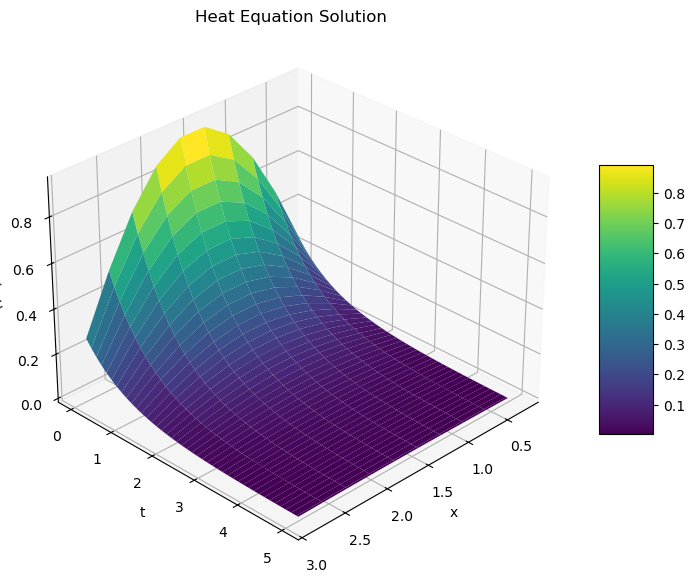

In [287]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

def plot_solution_3d(x_axis, t_axis, u_grid):
    """
    Plot 3D surface of solution (interactive).
    
    Args:
        x_axis: 1D array of x values
        t_axis: 1D array of t values
        u_grid: 2D array of shape (len(x_axis), len(t_axis))
    """
    X, T = np.meshgrid(x_axis, t_axis, indexing='ij')
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    surf = ax.plot_surface(X, T, u_grid, cmap='viridis')
    
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u(x,t)')
    ax.set_title('Heat Equation Solution')
    ax.view_init(elev=30, azim=45)
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    plt.show()

# Usage with your data:
x_grid, t_grid, u_grid, h_x, h_t = u_grids[0]  # pick a solution
plot_solution_3d(x_grid, t_grid, u_grid)

# Error calculation setup

In [288]:
def relative_error(x_grid, t_grid, u_grid, fn):
    # print(f"x_grid: {x_grid}")
    gt_samples = np.array([
        [fn(x, t) for t in t_grid]
    for x in x_grid])
    # print(f"u shape: {u_grid.shape}")
    errors = u_grid - gt_samples
    err_norm = np.linalg.norm(errors, axis=1)
    solution_norm = np.linalg.norm(gt_samples, axis=1)
    # print(f"u norm: {solution_norm}, err : {err_norm}")
    # print(f"div: {err_norm / solution_norm}")
    # print(f"gt norm: {np.linalg.norm(gt_samples)}")
    return err_norm / solution_norm

In [289]:
def calc_rel_err_under(u_grids):
    err_grids = []
    for s in u_grids:
        x_grid, t_grid, u_grid, h_x, h_t = s
        rel_err_vec = relative_error(x_grid, t_grid, u_grid, gt_fn)
        infinte_norm = np.linalg.norm(rel_err_vec, ord=np.inf)

        err_grids.append((x_grid, t_grid, u_grid, h_x, h_t, infinte_norm))
        # print(f"h_x: {h_x}, h_t: {h_t} max: {infinte_norm}")

    return err_grids

def find_rel_err_under(err_grids, percent=0.02):
    for s in err_grids:
        if s[-1] <= percent:
            return s


In [290]:
def plot_errs_vs_ht(h_ts, errs):
    plt.figure(figsize=(6,4))
    plt.plot(h_ts, errs, '-o')

    # plt.xticks(h_ts)

    # plt.yticks(errs)

    plt.xlabel('h_t')
    plt.ylabel('max relative error (inf norm)')
    plt.title('Error vs time step h_t')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


# Relative error Calculation

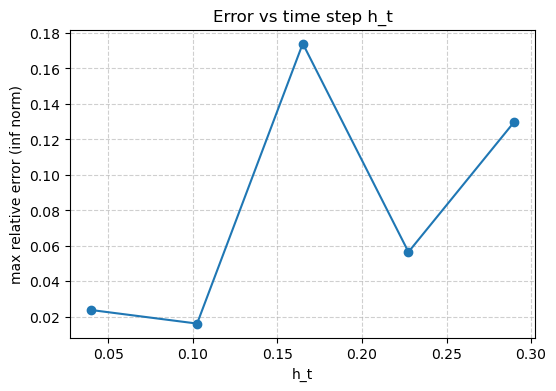

In [291]:
u_grids_err = calc_rel_err_under(u_grids)

def plot_err_across_search_domain(u_grids_err):
    hts = [h_t for x_grid, t_grid, u_grid, h_x, h_t, err in u_grids_err]
    errs = [err for x_grid, t_grid, u_grid, h_x, h_t, err in u_grids_err]
    plot_errs_vs_ht(hts, errs)

plot_err_across_search_domain(u_grids_err)


h_t: 0.04


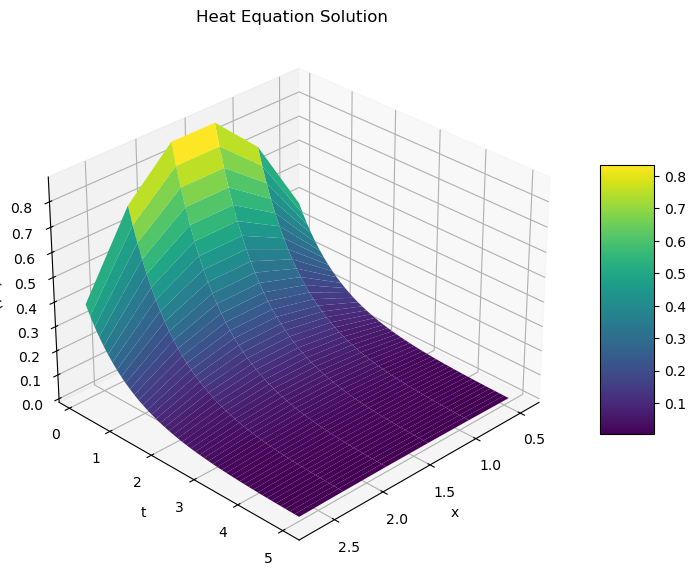

In [292]:
acc_x, acc_t, acc_u, acc_h_x, acc_h_t, err = find_rel_err_under(u_grids_err)
print(f"h_t: {h_t}")
plot_solution_3d(acc_x, acc_t, acc_u)

calculating solutions:


100%|██████████| 3/3 [00:00<00:00, 857.50it/s]

h_t: 0.0256, h_x: 0.2264 grid: 13 x 195
h_t: 0.0512, h_x: 0.3202 grid: 9 x 98
h_t: 0.1025, h_x: 0.4528 grid: 6 x 49
calculating relative error:
hts_0: [0.025625, 0.05125, 0.1025]
errs_0: [0.007004901039470091, 0.012057601330919938, 0.01609263441077463]


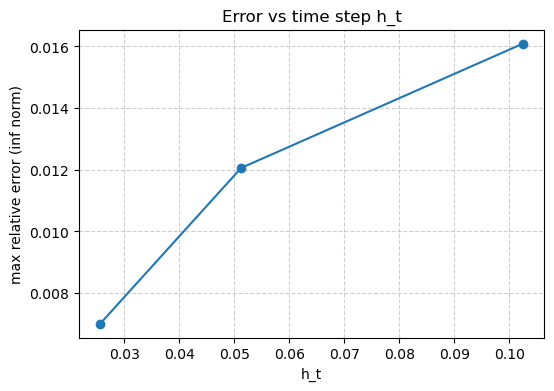

1.33464641673858
1.7213093037260203


In [294]:
hts_0 = [acc_h_t/ 4, acc_h_t / 2, acc_h_t]
print(f"calculating solutions:")
u_grids_0 = [get_solution_from_ht(h_t) for h_t in tqdm(hts_0)]

print(f"calculating relative error:")
errs_0 = [np.linalg.norm(relative_error(x_grid, t_grid, u_grid, gt_fn), ord=np.inf) for x_grid, t_grid, u_grid, h_x, h_t in u_grids_0]

print(f"hts_0: {hts_0}")
print(f"errs_0: {errs_0}")

plot_errs_vs_ht(hts_0, errs_0)
print(errs_0[-1] / errs_0[-2])
print(errs_0[-2] / errs_0[-3])

# 4.2